# Create Environment

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=1000

global T
global target
T=20
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.5,0.75,1,1.25,1.5]

global num_system
num_system=5

In [2]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [3]:
def next_step(vecs,action):
    vecs_new=[]
    u=action[0]
    v=action[1]
    diff=Z(vecs,u,v)
    for i in range(num_system):
        w=vecs[i]+delta_t*diff[i]
        '''
        if w[2]>np.pi:
            w[2]-=2*np.pi
        if w[2]<-np.pi:
            w[2]+=2*np.pi
        '''
        vecs_new.append(w)
    return np.array(vecs_new)

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return -(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4]

# Learning Settings

In [4]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(theta,cand,init=False):
    explo=exploration()
    if init or explo:
        return(np.random.randint(6)), True
    else:
        return(find_max(cand)), False
    
def decide_u_exploitation(theta,cand,init=False):
    return find_max(cand)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
flags=[True for i in range(6)]

# Simulation


In [5]:
num_iter=50

position_result=[]
observation_result=[]
gpr_list=[]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(5)]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
    observation=observe(position)
    u_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(5)]
    
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            u_k, _ = decide_u(observation,candidates_u,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:            
            candidates_u=[]
            for i in range(6):
                cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
                candidates_u.append(cand[0])
            #print(candidates_u)
            u_k, explo = decide_u(observation,np.array(candidates_u))
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
            
            
            if abs(r)<0.03:
                break
            

    if iterr==0:
        for i in range(6):
            gpr_list.append(GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_r[i].reshape(-1,1)))
    else:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_r[i].reshape(-1,1))
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
    
    #print(history_su.shape)
    #print(u_t)

  2%|█▋                                                                                 | 1/50 [00:00<00:07,  6.17it/s]

observation = [-0.3263841  -1.81166519 -0.09424778  0.33563     0.01400324]


  4%|███▎                                                                               | 2/50 [00:02<01:16,  1.60s/it]

observation = [-3.02927232  1.70430756 -0.43982297  4.95681955  3.08766122]


  6%|████▉                                                                              | 3/50 [00:05<01:36,  2.06s/it]

observation = [ 2.17920667 -0.12942008  0.86393798  2.54328687  4.99012748]


  8%|██████▋                                                                            | 4/50 [00:08<01:51,  2.43s/it]

observation = [ 2.70691314 -0.80216985  0.06283185  2.42124578  0.55859496]


 10%|████████▎                                                                          | 5/50 [00:11<02:04,  2.77s/it]

observation = [-1.18926999 -1.7386332   2.3090706   4.18235001  0.07790921]


 12%|█████████▉                                                                         | 6/50 [00:15<02:17,  3.13s/it]

observation = [-1.37565026  1.57035795 -1.13097336  0.04015646  3.75164746]


 14%|███████████▌                                                                       | 7/50 [00:20<02:33,  3.57s/it]

observation = [ 4.17905019  0.63637039 -0.06283185  2.49829332  2.11877541]


 16%|█████████████▎                                                                     | 8/50 [00:25<02:50,  4.06s/it]

observation = [1.31144483 0.99089251 1.44513262 0.17109738 1.99216446]


 18%|██████████████▉                                                                    | 9/50 [00:30<03:08,  4.61s/it]

observation = [3.69697096 0.52597428 0.48694686 2.32546412 2.17058027]


 20%|████████████████▍                                                                 | 10/50 [00:37<03:26,  5.16s/it]

observation = [ 1.4257383  -1.24193862 -1.13097336  2.41788028  0.08659489]


 22%|██████████████████                                                                | 11/50 [00:44<03:45,  5.77s/it]

observation = [ 2.67849306 -1.34641979  0.43982297  2.20314857  0.13328846]


 24%|███████████████████▋                                                              | 12/50 [00:52<04:03,  6.41s/it]

observation = [-1.1115818  -1.47244066  0.5969026   1.4288595   0.04778233]


 26%|█████████████████████▎                                                            | 13/50 [01:01<04:25,  7.17s/it]

observation = [2.9841973  1.52388498 0.78539816 0.52493124 3.08487455]


 28%|██████████████████████▉                                                           | 14/50 [01:12<04:59,  8.31s/it]

observation = [-1.11694476 -1.39423821 -0.97389372  0.46099512  0.08223797]


 30%|████████████████████████▌                                                         | 15/50 [01:31<06:44, 11.57s/it]

observation = [1.04145323 0.05899893 2.3090706  0.30146484 0.97867356]


 32%|██████████████████████████▏                                                       | 16/50 [01:44<06:45, 11.94s/it]

observation = [ 0.09776113  0.25803464 -1.66504411  2.62176039  1.07093511]


 34%|███████████████████████████▉                                                      | 17/50 [01:59<07:03, 12.83s/it]

observation = [3.28021128 1.91741165 2.56039801 0.96164475 5.22548273]


 36%|█████████████████████████████▌                                                    | 18/50 [02:14<07:17, 13.68s/it]

observation = [ 7.51134406 -0.83760748  0.15707963 10.47813717  0.53215705]


 38%|███████████████████████████████▏                                                  | 19/50 [02:30<07:22, 14.26s/it]

observation = [10.45864676  2.0760702   0.95818576  9.52789313  5.61420819]


 40%|████████████████████████████████▊                                                 | 20/50 [02:47<07:33, 15.12s/it]

observation = [ 6.69111587 -1.73469843  2.95309709 13.47589496  1.48240815]


 42%|██████████████████████████████████▍                                               | 21/50 [03:11<08:34, 17.75s/it]

observation = [3.51490011 0.60052927 1.19380521 1.18266644 1.57394742]


 44%|████████████████████████████████████                                              | 22/50 [03:34<09:01, 19.34s/it]

observation = [ 3.61709991 -2.66427581  1.57079633  6.30594087  0.04453636]


 46%|█████████████████████████████████████▋                                            | 23/50 [04:01<09:43, 21.62s/it]

observation = [-3.13461816 -0.25823359  2.45044227  0.63892488  6.42169027]


 48%|███████████████████████████████████████▎                                          | 24/50 [04:28<10:04, 23.26s/it]

observation = [ 3.03855937 -0.36628376  0.14137167  2.07039911  0.89730537]


 50%|█████████████████████████████████████████                                         | 25/50 [04:57<10:24, 24.99s/it]

observation = [ 0.43429018 -1.1227635  -0.7696902   1.72946071  0.11306713]


 52%|██████████████████████████████████████████▋                                       | 26/50 [05:28<10:42, 26.79s/it]

observation = [ 0.31108242 -0.54458797 -0.95818576  1.4253522   0.68558891]


 54%|████████████████████████████████████████████▎                                     | 27/50 [06:02<11:03, 28.85s/it]

observation = [ 0.71841616 -1.11423625 -0.65973446  3.07433048  0.73461353]


 56%|█████████████████████████████████████████████▉                                    | 28/50 [06:53<13:04, 35.65s/it]

observation = [-0.23905711 -0.8748331  -0.86393798  1.20999057  0.269212  ]


 58%|███████████████████████████████████████████████▌                                  | 29/50 [07:56<15:17, 43.69s/it]

observation = [ 2.3868629  -0.6427677   0.53407075  2.0743509   1.22720229]


 60%|█████████████████████████████████████████████████▏                                | 30/50 [09:03<16:58, 50.92s/it]

observation = [4.86620269 1.52663273 1.52367244 2.92199733 3.71971987]


 62%|██████████████████████████████████████████████████▊                               | 31/50 [10:09<17:34, 55.48s/it]

observation = [ 2.64258301 -1.50453475  0.37699112  4.18886161  0.02850826]


 64%|████████████████████████████████████████████████████▍                             | 32/50 [11:17<17:41, 58.99s/it]

observation = [ 1.21053445  0.65136991 -2.56039801  5.27931542  0.7924415 ]


 66%|██████████████████████████████████████████████████████                            | 33/50 [12:29<17:49, 62.92s/it]

observation = [ 0.42371922  0.22710987 -0.73827427  1.90451594  1.61391502]


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [13:47<18:01, 67.58s/it]

observation = [ 0.75163751  0.02238579 -0.9424778   3.36140463  0.83294811]


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [15:07<17:48, 71.21s/it]

observation = [ 0.48766714 -0.4850475  -0.67544242  2.81698741  0.33831583]


 72%|███████████████████████████████████████████████████████████                       | 36/50 [16:34<17:43, 75.99s/it]

observation = [ 1.12376503 -0.48020382 -0.97389372  1.83086744  0.80462219]


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [18:12<17:53, 82.57s/it]

observation = [ 1.56753222 -0.21258783 -0.86393798  2.416316    0.98575801]


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [19:51<17:30, 87.52s/it]

observation = [ 2.20540286 -1.92094391 -0.03141593  2.19026111  0.00250571]


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [21:34<16:52, 92.06s/it]

observation = [ 1.30891819 -1.90656019 -0.26703538  1.46268362  0.00196493]


 80%|████████████████████████████████████████████████████████████████▊                | 40/50 [23:46<17:20, 104.07s/it]

observation = [ 2.05837789 -2.55853856 -0.06283185  2.0023778   0.12604781]


 82%|██████████████████████████████████████████████████████████████████▍              | 41/50 [25:29<15:33, 103.67s/it]

observation = [ 4.03648541 -1.18867392  1.13097336  4.50564522  0.32351296]


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [26:43<12:40, 95.02s/it]

observation = [ 1.52755429 -2.12528056 -0.20420352  1.6812406   0.00857339]


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [27:56<10:18, 88.43s/it]

observation = [ 0.37777998 -1.39591413 -0.58119464  1.01178934  0.11714033]


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [29:10<08:23, 83.92s/it]

observation = [ 3.77579315 -2.09492653  0.25132741  3.79012273  0.00398911]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [30:31<06:54, 82.97s/it]

observation = [ 2.04183774 -2.38798626 -0.07853982  1.91266622  0.05934023]


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [31:54<05:32, 83.05s/it]

observation = [ 1.01217656 -0.99253973 -0.83252205  1.2876309   0.37967751]


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [33:18<04:10, 83.44s/it]

observation = [ 0.09852625 -1.70957258 -0.89535391  0.75760498  0.02326154]


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [34:51<02:52, 86.26s/it]

observation = [ 5.76486524 -0.72277218  0.40840704  5.80976042  0.57644077]


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [36:25<01:28, 88.56s/it]

observation = [ 3.23581991 -1.84011115  0.2984513   2.92553837  0.00773754]


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [38:02<00:00, 45.65s/it]

observation = [ 4.53868962 -0.44392896  0.95818576  2.823562    0.53273571]


# Results

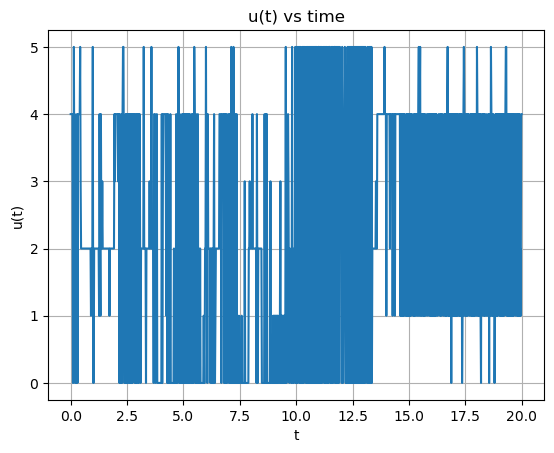

In [6]:
x = np.linspace(0, T, N+1)
plt.plot(x, u_t)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


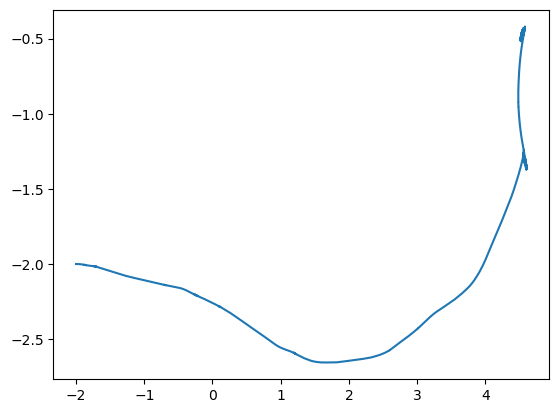

In [7]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

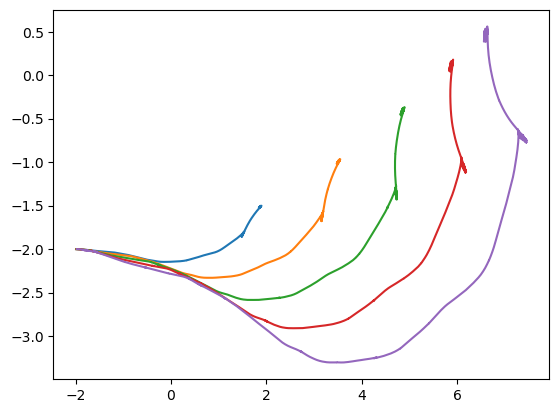

In [8]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

## Best Trajectory

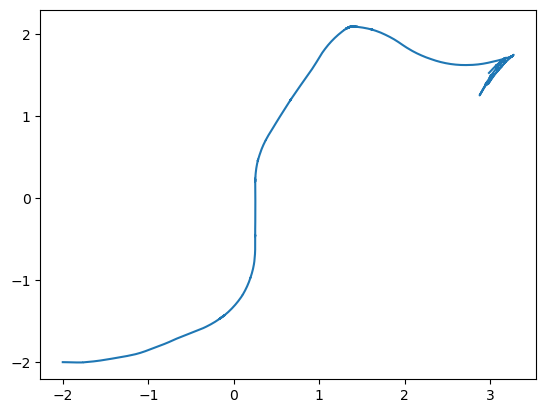

In [9]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

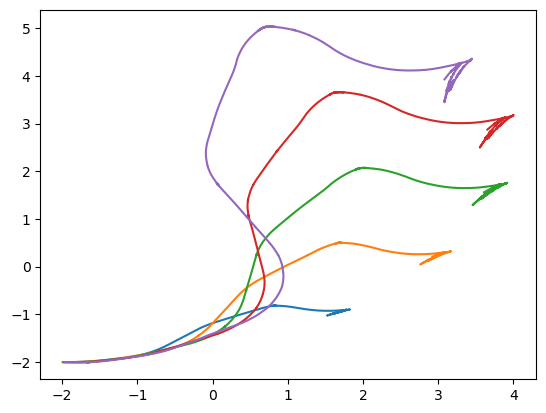

In [10]:
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

## Pure Exploitation Trajectory

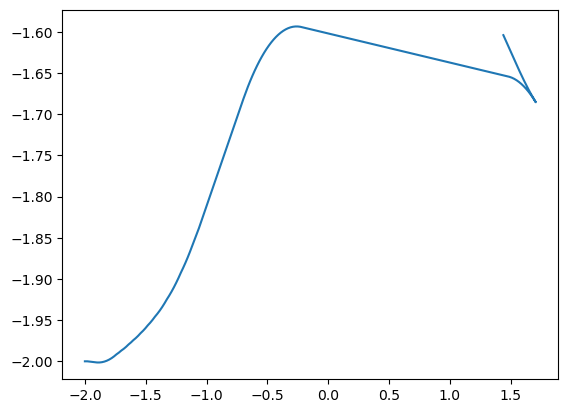

In [11]:
position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(5)]

for time in range(N+1):           
    candidates_u=[]
    for i in range(6):
        cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
        candidates_u.append(cand[0])
    #print(candidates_u)
    u_k = decide_u_exploitation(observation,np.array(candidates_u))
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.show()

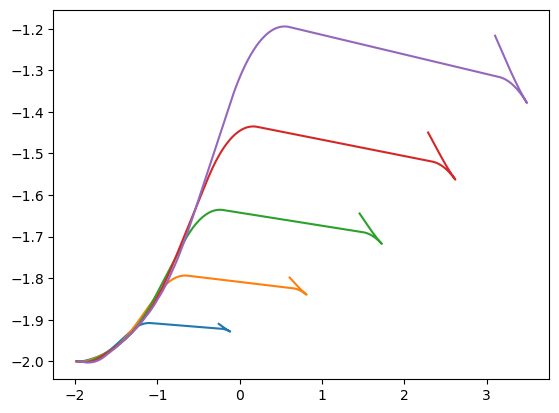

In [12]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.show()

In [13]:
print(observation_t[-1])

[ 1.43957302 -1.60387761 -0.28274334  1.41089982  0.06137203]
